## Loading dataset

In [1]:
!pip install opendatasets -q
import opendatasets as od
od.download(
    "https://www.kaggle.com/datasets/adityajn105/flickr8k/data")



Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: maramabdelnasser
Your Kaggle Key: ··········


100%|██████████| 1.04G/1.04G [00:11<00:00, 95.0MB/s]


## import liberaries

In [2]:
import os
import string
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from pickle import dump, load
from keras.applications.xception import Xception, preprocess_input
from keras.applications import VGG16, ResNet50, DenseNet201

from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import concatenate
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

# small library for seeing the progress of loops.
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

<ipython-input-2-7abacc798598>:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


0it [00:00, ?it/s]

## Captions Preprocessing


In [3]:
# Loading a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# get all imgs with their captions
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for cap in captions[:-1]:
        result = cap.split(",")#it returns two values [values[0]->images , values[1]->caption]
        if result[0] not in descriptions:
            descriptions[result[0]] = [ result[1]]
        else:
            descriptions[result[0]].append(result[1])
    return descriptions

#Data cleaning- lower casing, removing puntuations and numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            desc = img_caption.split()

            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove extra spaces and single chracters(a,..)
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string
            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]

    return vocab

#All descriptions in one file
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [4]:
# Set these path according to project folder in you system
dataset_text   = "/content/flickr8k/captions.txt"
dataset_images = "/content/flickr8k/Images"

#we prepare our text data
filename = dataset_text
#loading the file that contains all data
#mapping them into descriptions dictionary img to 5 captions
descriptions = all_img_captions(filename)
print("Length of descriptions =" ,len(descriptions))

#cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)

#building vocabulary
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))

#saving each description to file
save_descriptions(clean_descriptions, "descriptions.txt")

Length of descriptions = 8092
Length of vocabulary =  8572


## Visualization

In [ ]:
from textwrap import wrap

data = pd.read_csv(dataset_text)

def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/content/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

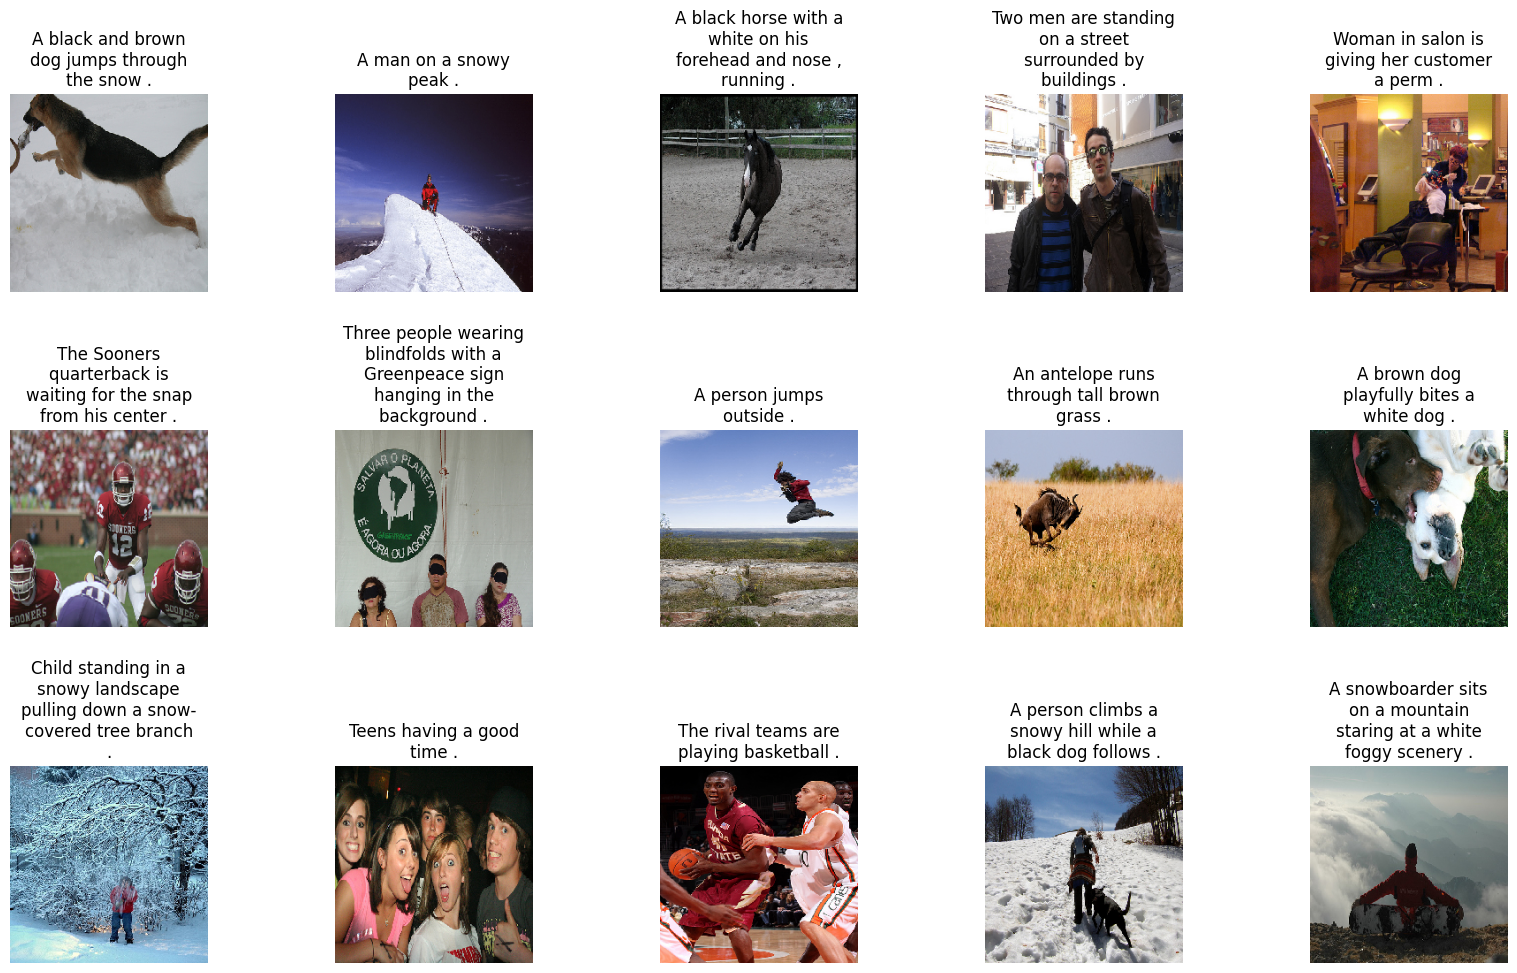

In [ ]:
display_images(data.sample(15))

### Xception Model

In [15]:
def extract_features(directory):
        model = Xception( include_top=False, pooling='avg')
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            image = image/127.5
            image = image - 1.0

            feature = model.predict(image)
            features[img] = feature
        return features

#2048 feature vector
features = extract_features(dataset_images)
dump(features, open("Xception_features.p","wb"))

#loading features file
features = load(open("Xception_features.p","rb"))

<ipython-input-15-0e4e1c3b8c12>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img in tqdm(os.listdir(directory)):


  0%|          | 0/8091 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 22ms/step


### DenseNet201 Model

In [21]:
def extract_features(directory):
        model = DenseNet201( include_top=False, pooling='avg' )
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((224,224))
            image = np.expand_dims(image, axis=0)
            image = image/127.5
            image = image - 1.0

            feature = model.predict(image)
            features[img] = feature
        return features

#2048 feature vector
features = extract_features(dataset_images)

dump(features, open("DenseNet_features.p","wb"))
#loading features file
features = load(open("DenseNet_features.p","rb"))

<ipython-input-21-a10d253af0c7>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img in tqdm(os.listdir(directory)):


  0%|          | 0/8091 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 45ms/step


### VGG16 Model

In [27]:
def extract_features(directory):
        model = VGG16( include_top=False, pooling='avg' )
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((224,224))
            image = np.expand_dims(image, axis=0)
            image = image/127.5
            image = image - 1.0

            feature = model.predict(image)
            features[img] = feature
        return features

#2048 feature vector
features = extract_features(dataset_images)
dump(features, open("VGG16_features.p","wb"))
#loading features file
features = load(open("VGG16_features.p","rb"))

58889256/58889256 [==============================] - 0s 0us/step


<ipython-input-27-6cdec0c7dc41>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img in tqdm(os.listdir(directory)):


  0%|          | 0/8091 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 20ms/step


### ResNet50 Model

In [28]:
def extract_features(directory):
        model = ResNet50( include_top=False, pooling='avg' )
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((224,224))
            image = np.expand_dims(image, axis=0)
            image = image/127.5
            image = image - 1.0

            feature = model.predict(image)
            features[img] = feature
        return features

#2048 feature vector
features = extract_features(dataset_images)
dump(features, open("ResNet50_features.p","wb"))
#loading features file
features = load(open("ResNet50_features.p","rb"))

94765736/94765736 [==============================] - 0s 0us/step


<ipython-input-28-924b83a7c371>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img in tqdm(os.listdir(directory)):


  0%|          | 0/8091 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 39ms/step


## loading the preprocessed images and descriptions(captions)


In [32]:
#loading images
def load_photos(filename):
    photos=[]
    file = load_doc(filename)
    lines = file.split("\n")
    for line in lines[1:-1]:
      result=line.split(",")
      photos.append(result[0])
    return  photos

def load_clean_descriptions(filename, photos):
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):

        words = line.split()
        if len(words)<1 :
            continue

        image, image_caption = words[0], words[1:]

        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)

    return descriptions

#previously extracted features from the Xception model.
def Xception_features(photos):
    #loading all features
    all_features = load(open("Xception_features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features

#previously extracted features from the DenseNet model.
def DenseNet_features(photos):
    #loading all features
    all_features = load(open("DenseNet_features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features

#previously extracted features from the VGG16 model.
def VGG16_features(photos):
    #loading all features
    all_features = load(open("VGG16_features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features

#previously extracted features from the ResNet model.
def ResNet_features(photos):
    #loading all features
    all_features = load(open("ResNet50_features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features

## Training Models

In [33]:
#Xception Model
#train = loading_data(filename)
train_imgs = load_photos(filename)
train_features = Xception_features(train_imgs)

#DenseNet Model
#train = loading_data(filename)
train_imgs = load_photos(filename)
DenseNet_train_features = DenseNet_features(train_imgs)

#VGG16 Model
#train = loading_data(filename)
train_imgs = load_photos(filename)
VGG16_train_features = VGG16_features(train_imgs)

#ResNet Model
#train = loading_data(filename)
train_imgs = load_photos(filename)
ResNet50_train_features = ResNet_features(train_imgs)

## Tokenization

In [34]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#creating tokenizer class
#this will vectorise text corpus
#each integer will represent token in dictionary

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

# give each word an index, and store that into tokenizer.p pickle file
train_descriptions = load_clean_descriptions("/descriptions.txt", train_imgs)
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8572

In [35]:
#calculate maximum length of descriptions
#needed as input to LSTM
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

max_length = max_length(descriptions)
max_length

29

## Generate Captions

In [45]:
#create input-output sequence pairs from the image description.

#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

#You can check the shape of the input and output for your model
#run this cell to get the train feuters of the model you want to use
[a,b],c = next(data_generator(train_descriptions, DenseNet_train_features, tokenizer, max_length))
a.shape, b.shape, c.shape

#Xception Parameters ((47, 2048), (47, 29), (47, 8572))
#DenseNet Parameters ((47, 1920), (47, 29), (47, 8572))
#VGG16 Parameters ((47, 512), (47, 29), (47, 8572))

((47, 1920), (47, 29), (47, 8572))

## Bulding Models

### xception

In [37]:
from keras.utils import plot_model

# define the captioning model
def define_Xception(vocab_size, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = concatenate([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

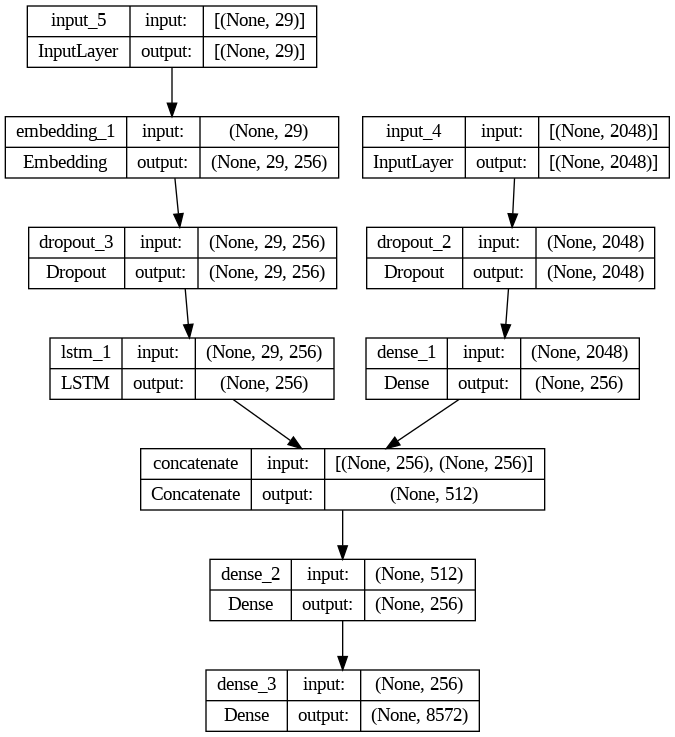

In [39]:
from IPython.display import display,Image
from IPython import display
display.clear_output()
Image(filename='/content/model.png' , height=600)

### DenseNet

In [46]:
#DenseNet
# define the captioning model
def define_model(vocab_size, max_length):

    # features from the CNN model squeezed from 1920 to 256 nodes
    inputs1 = Input(shape=(1920,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = concatenate([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model2.png', show_shapes=True)

    return model

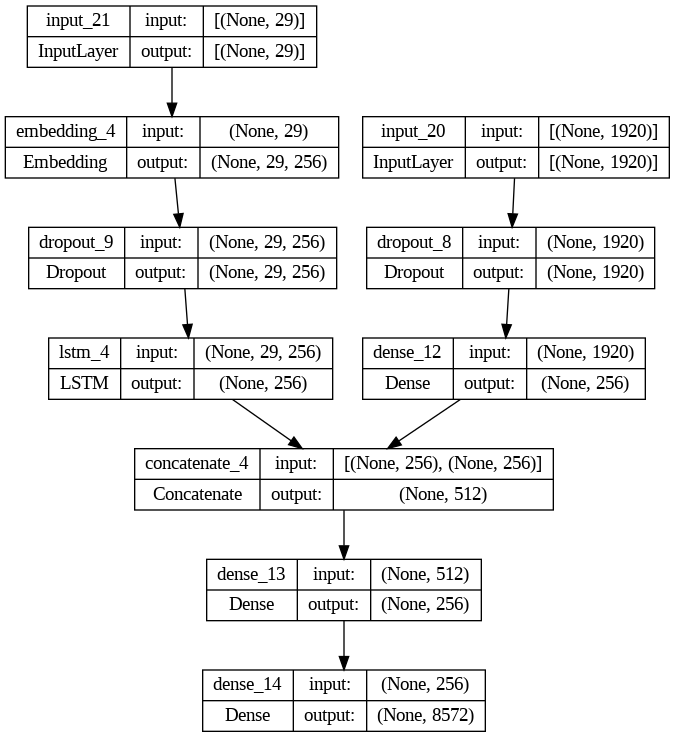

In [2]:
from IPython.display import display,Image
from IPython import display
display.clear_output()
Image(filename='model2.png' , height=600)

### VGG16

In [ ]:
# define the captioning model
def define_VGG16(vocab_size, max_length):

    # features from the CNN model squeezed from ? to 256 nodes
    
    ####### error is here
    inputs1 = Input(shape=(512,)) # run after getting its shape
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = concatenate([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model3.png', show_shapes=True)

    return model

display.clear_output()
Image(filename='/content/model3.png' , height=600)

### ResNet50

In [ ]:
# define the captioning model
def define_ResNet50(vocab_size, max_length):

    # features from the CNN model squeezed from ? to 256 nodes
    #get this number from Generate caption cell and don't forget to tune the features to the one used here

    inputs1 = Input(shape=(2048,)) 
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = concatenate([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model4.png', show_shapes=True)

    return model

display.clear_output()
Image(filename='/content/model4.png' , height=600)

## Model training

### Xception

In [ ]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_VGG16(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
# making a directory models to save our models
os.mkdir("models1")
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("models1/model_" + str(i) + ".h5")

Dataset:  40455
Descriptions: train= 8091
Photos: train= 8091
Vocabulary Size: 8572
Description Length:  29
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 29)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 29, 256)              2194432   ['input_5[0][0]']             
                                                                                                  
 dropout_2 (Dropout)         (None, 2048)                 0         ['input_4[0][0]']

<ipython-input-93-7600b5951421>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)


8091/8091 [==============================] - 723s 88ms/step - loss: 4.3528


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8091/8091 [==============================] - 639s 79ms/step - loss: 2.8917


### DenseNet

In [ ]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(DenseNet_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
# making a directory models to save our models
os.mkdir("models")
for i in range(epochs):
    generator = data_generator(train_descriptions, DenseNet_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("models/model_" + str(i) + ".h5")

Dataset:  40455
Descriptions: train= 8091
Photos: train= 8091
Vocabulary Size: 8572
Description Length:  29
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 29)]                 0         []                            
                                                                                                  
 input_20 (InputLayer)       [(None, 1920)]               0         []                            
                                                                                                  
 embedding_4 (Embedding)     (None, 29, 256)              2194432   ['input_21[0][0]']            
                                                                                                  
 dropout_8 (Dropout)         (None, 1920)                 0         ['input_20[0][0

<ipython-input-47-f7a2dcab78e2>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)


8091/8091 [==============================] - 764s 94ms/step - loss: 4.3864


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2798/8091 [=========>....................] - ETA: 7:05 - loss: 3.2660

### VGG16

In [ ]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(VGG16_train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_VGG16(vocab_size, max_length)
epochs = 5
steps = len(train_descriptions)
# making a directory models to save our models
os.mkdir("models3")
for i in range(epochs):
    generator = data_generator(train_descriptions, VGG16_train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("models3/model_" + str(i) + ".h5")

### ResNet

In [ ]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(ResNet50_train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_VGG16(vocab_size, max_length)
epochs = 5
steps = len(train_descriptions)
# making a directory models to save our models
os.mkdir("models4")
for i in range(epochs):
    generator = data_generator(train_descriptions, ResNet50_train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("models4/model_" + str(i) + ".h5")

## Testing

In [ ]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
          return word
    return None


def extract_features(filename, model):
        image = Image.open(filename)
        image = image.resize((299,299))
        image = np.array(image)
        #if images that has 4 channels, convert them into 3 channels
        if image.shape[2] == 4:
             image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

1/1 [==============================] - 2s 2s/step





start man is climbing up snowy mountain end


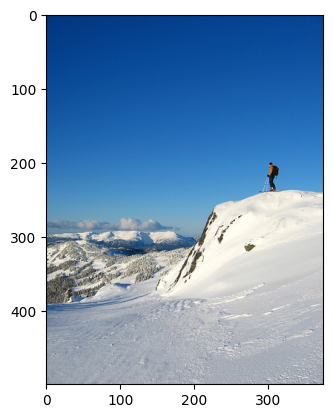

In [ ]:
img_path = '/content/flickr8k/Images/106514190_bae200f463.jpg'
max_length = 29
tokenizer = load(open("/content/tokenizer.p","rb"))
model = load_model('/content/model_9.h5')
xception_model = Xception(include_top=False, pooling="avg")

photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)